## Importing Required Libraries

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from glob import glob
from PIL import Image
import os
import random
# import cv2

import os
import random
import keras

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.layers import Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.models import Sequential
from keras.metrics import PrecisionAtRecall,Recall 
#Model Analysis
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from tensorflow.keras.metrics import TruePositives, FalsePositives, TrueNegatives, FalseNegatives, Precision, Recall, AUC

Init Plugin
Init Graph Optimizer
Init Kernel


## Extracting Files

In [2]:
# c = '../input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images'
# n = '../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images'
# p = '../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/images'


c = '/content/drive/Othercomputers/My MacBook Air/Upgrad ML/LJMU_MS/Model Building/COVID-19_Radiography_Dataset/COVID/images'
n = '/content/drive/Othercomputers/My MacBook Air/Upgrad ML/LJMU_MS/Model Building/COVID-19_Radiography_Dataset/Normal/images'
p = '/content/drive/Othercomputers/My MacBook Air/Upgrad ML/LJMU_MS/Model Building/COVID-19_Radiography_Dataset/Viral Pneumonia/images'

In [3]:
random.seed(42)
filenames = random.sample(os.listdir(c), 2000) + random.sample(os.listdir(n), 2000) + os.listdir(p)

In [4]:
len(filenames)

5345

### Classes
* 0 -> Normal
* 1 -> Viral Pneumonia
* 2 -> COVID

In [5]:
%%time
categories = []
for filename in filenames:
    category = filename.split('-')[0]
    if category == 'COVID':
        categories.append(str(2))
    elif category == 'Viral Pneumonia':
        categories.append(str(1))
    else:
        categories.append(str(0))

CPU times: user 3.57 ms, sys: 0 ns, total: 3.57 ms
Wall time: 3.54 ms


## Converting to Dataframe

In [6]:
%%time
for i in range(len(filenames)):
    if 'COVID' in filenames[i]:
        filenames[i] = os.path.join(c, filenames[i])
    elif 'Viral Pneumonia' in filenames[i]:
        filenames[i] = os.path.join(p, filenames[i])
    else:
        filenames[i] = os.path.join(n, filenames[i])
    
    
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

CPU times: user 8.38 ms, sys: 2.92 ms, total: 11.3 ms
Wall time: 13.9 ms


In [7]:
df.head()

,filename,category
0,../input/covid19-radiography-database/COVID-19...,2
1,../input/covid19-radiography-database/COVID-19...,2
2,../input/covid19-radiography-database/COVID-19...,2
3,../input/covid19-radiography-database/COVID-19...,2
4,../input/covid19-radiography-database/COVID-19...,2


## Exploratory Data Analysis and Data Visualization

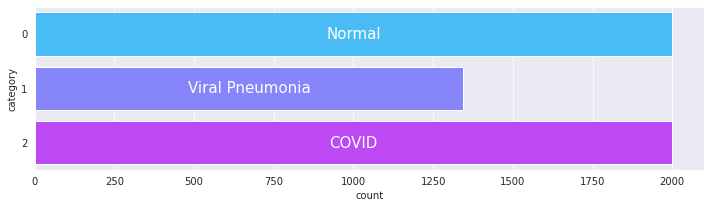

In [8]:
plt.figure(figsize=(12,3))
splot = sns.countplot(data = df.sort_values(by='category'), y ='category', palette='cool', saturation=0.9)
plt.bar_label(container=splot.containers[0], 
              labels=['Normal', 'Viral Pneumonia', 'COVID'], 
              label_type='center', size=15, color='w')
plt.show()

In [9]:
%%time
df['image'] = df['filename'].map(lambda x: np.asarray(Image.open(x).resize((75,75))))

CPU times: user 10.7 s, sys: 566 ms, total: 11.3 s
Wall time: 36.6 s


In [10]:
mean_val = []
std_dev_val = []
max_val = []
min_val = []

cv2.imread

for i in range(0,len(df)):
    mean_val.append(df['image'][i].mean())
    std_dev_val.append(np.std(df['image'][i]))
    max_val.append(df['image'][i].max())
    min_val.append(df['image'][i].min())

imageEDA = df.loc[:,['image', 'category']]
imageEDA['mean'] = mean_val
imageEDA['stedev'] = std_dev_val
imageEDA['max'] = max_val
imageEDA['min'] = min_val

subt_mean_samples = imageEDA['mean'].mean() - imageEDA['mean']
imageEDA['subt_mean'] = subt_mean_samples


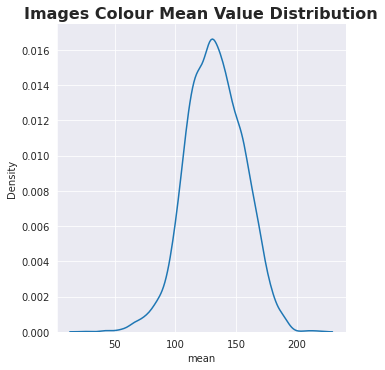

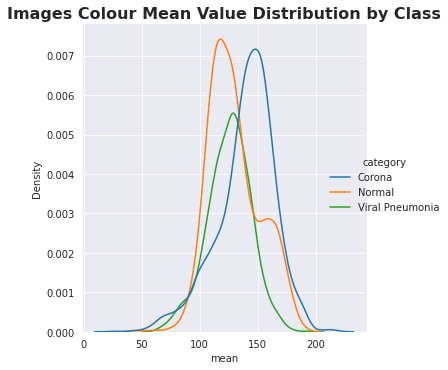

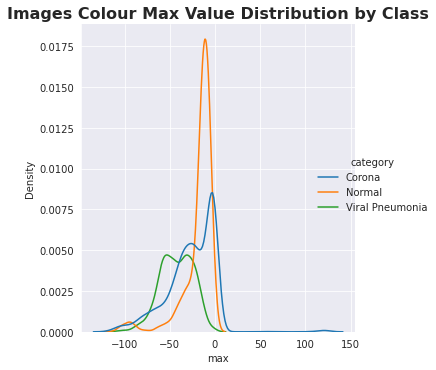

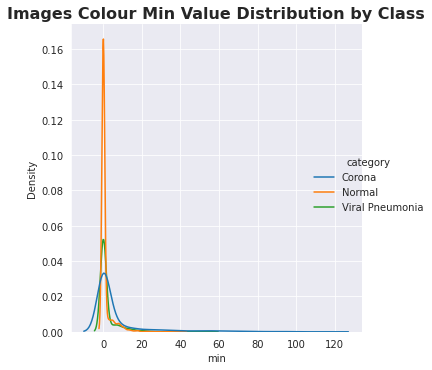

In [11]:
ax = sns.displot(data = imageEDA, x = 'mean', kind="kde");
plt.title('Images Colour Mean Value Distribution', fontsize = 16,weight = 'bold');

ax = sns.displot(data = imageEDA, x = 'mean', kind="kde", hue = 'category');
plt.title('Images Colour Mean Value Distribution by Class', fontsize = 16,weight = 'bold');
new_labels = ['Corona', 'Normal','Viral Pneumonia']
for t, l in zip(ax._legend.texts, new_labels):
    t.set_text(l)
    
ax = sns.displot(data = imageEDA, x = 'max', kind="kde", hue = 'category');
plt.title('Images Colour Max Value Distribution by Class', fontsize = 16,weight = 'bold');
new_labels = ['Corona', 'Normal','Viral Pneumonia']
for t, l in zip(ax._legend.texts, new_labels):
    t.set_text(l)
    
ax = sns.displot(data = imageEDA, x = 'min', kind="kde", hue = 'category');
plt.title('Images Colour Min Value Distribution by Class', fontsize = 16,weight = 'bold');
new_labels = ['Corona', 'Normal','Viral Pneumonia']
for t, l in zip(ax._legend.texts, new_labels):
    t.set_text(l)

* Separating by class we can visualise that the Mean, Max and Min values vary according to the image class
* Viral Pneumonia is the only class that presents a Normal-like distribution across the three different analysis
* The Max value possible for an image is 255. Most classes peak around this number as expected
* Viral Pneumonia is the class that present the most samples with lower Max values if compared to the others. Most samples are within the 200 - 225 range
* Regarding the Max values, Lung Opacity and Covid-19 present similar distributions (see the "bumps"), while Normal patients have a peak at 150 and then another peak around 250

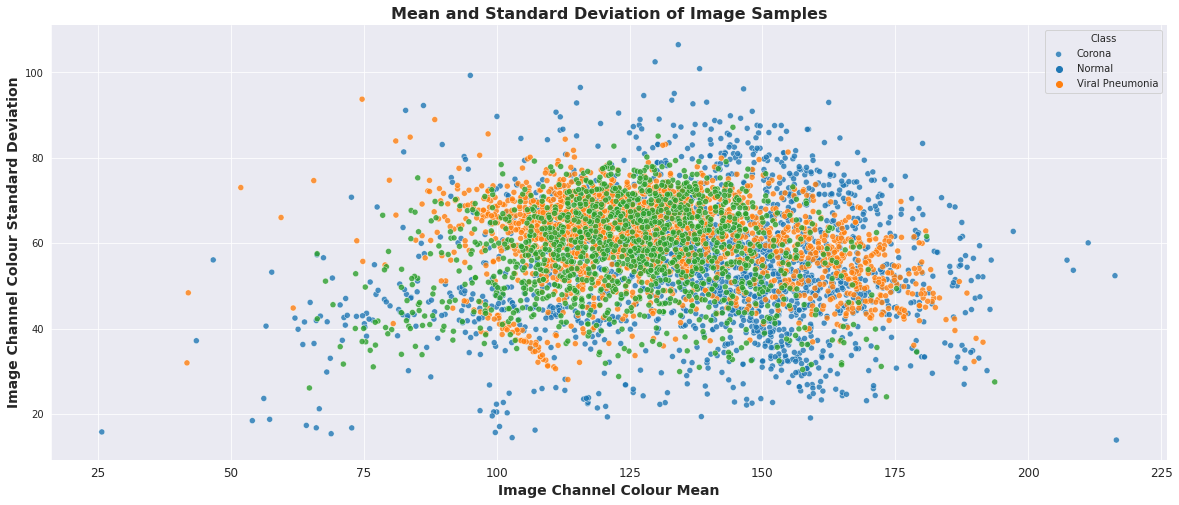

In [12]:
plt.figure(figsize=(20,8))
# sns.set(style="ticks", font_scale = 1)
ax = sns.scatterplot(data=imageEDA, x="mean", y=imageEDA['stedev'], hue = 'category',alpha=0.8);
sns.despine(top=True, right=True, left=False, bottom=False)
plt.xticks(rotation=0,fontsize = 12)
ax.set_xlabel('Image Channel Colour Mean',fontsize = 14,weight = 'bold')
ax.set_ylabel('Image Channel Colour Standard Deviation',fontsize = 14,weight = 'bold')
plt.title('Mean and Standard Deviation of Image Samples', fontsize = 16,weight = 'bold');
new_labels = ['Corona', 'Normal','Viral Pneumonia']
plt.legend(title='Class', loc='upper right', labels=new_labels)
plt.show(ax)

* Most images are gathered in the central region of the scatter plot, i.e. there is not much contrast between their pixel values
* Covid-19 samples seem to be the only class to have a small cluster of data on the bottom left side of the plot, where samples with a lower mean and low standard variation lie
* An individual plot by class is required, as the classes are on top of each other and we might miss important details
* We see that all classes have outliers spread around the peripheric area of the graph. It will be interesting to use visualisation to understand how the outliers look like

<Figure size 1440x576 with 0 Axes>

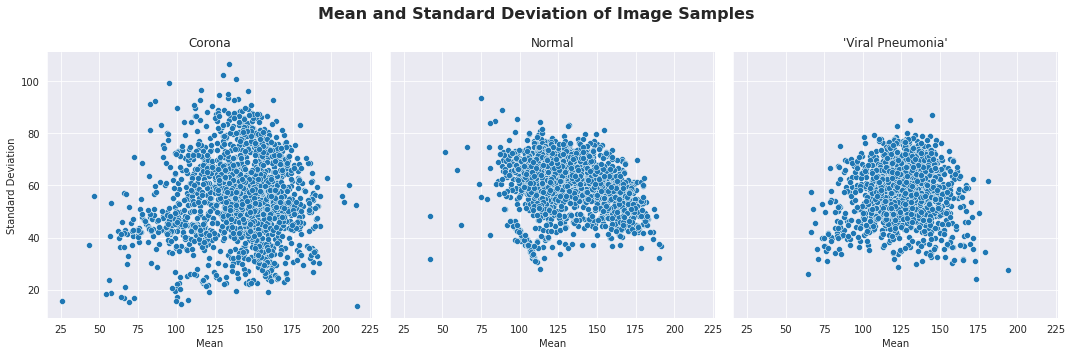

In [13]:
plt.figure(figsize=(20,8));
g = sns.FacetGrid(imageEDA, col="category",height=5);
g.map_dataframe(sns.scatterplot, x='mean', y='stedev');
g.fig.subplots_adjust(top=.7)
g.fig.suptitle('Mean and Standard Deviation of Image Samples',fontsize=16, weight = 'bold')
axes = g.axes.flatten()
axes[0].set_ylabel('Standard Deviation');
axes[0].set_title("Corona")
axes[1].set_title("Normal")
axes[2].set_title("'Viral Pneumonia'")
for ax in axes:
    ax.set_xlabel('Mean')
g.fig.tight_layout()

* Viral Pneumonia images display a more concentrated scatter, perhaps these images have higher similarity to each other than compared to the other classes
* The Covid-19 scatter does not resemble any of the other three classes. It presents more outliers than the other classes, and the points are more scattered across the graph. It could indicate that the images have a higher distinction between each other

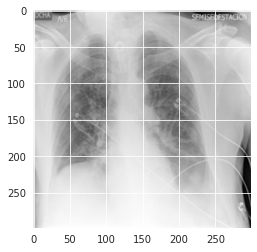

In [14]:
sample = random.choice(df['filename'])
image = load_img(sample)
plt.imshow(image)
plt.show()

## Splitting Train, Validation & Test Data

In [15]:
train_data, test_valid_data = train_test_split(df, test_size=0.3, random_state = 42, shuffle=True, stratify=df['category'])
train_data = train_data.reset_index(drop=True)
test_valid_data = test_valid_data.reset_index(drop=True)

In [16]:
test_data, valid_data = train_test_split(test_valid_data, test_size=0.5, random_state = 42,
                                         shuffle=True, stratify=test_valid_data['category'])
test_data = test_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)

## Data Augmentation

In [17]:
%%time
train_data_gen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

CPU times: user 191 µs, sys: 0 ns, total: 191 µs
Wall time: 196 µs


In [18]:
%%time
train_generator = train_data_gen.flow_from_dataframe(
    train_data, 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=15
)

Found 3741 validated image filenames belonging to 3 classes.
CPU times: user 45.7 ms, sys: 74.9 ms, total: 121 ms
Wall time: 1.5 s


In [19]:
%%time
valid_data_gen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_data_gen.flow_from_dataframe(
    valid_data, 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=15
)

Found 802 validated image filenames belonging to 3 classes.
CPU times: user 17.3 ms, sys: 11.8 ms, total: 29.1 ms
Wall time: 319 ms


## Model Training - VGG16

#### Model Architecture

In [20]:
baseModel = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))
headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.3)(headModel)
headModel = Dense(3, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)
for layer in baseModel.layers:
    layer.trainable = False


2022-10-16 11:43:51.920273: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-16 11:43:52.016238: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-16 11:43:52.017113: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-16 11:43:52.019007: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 0s 0us/step


#### Model Summary

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

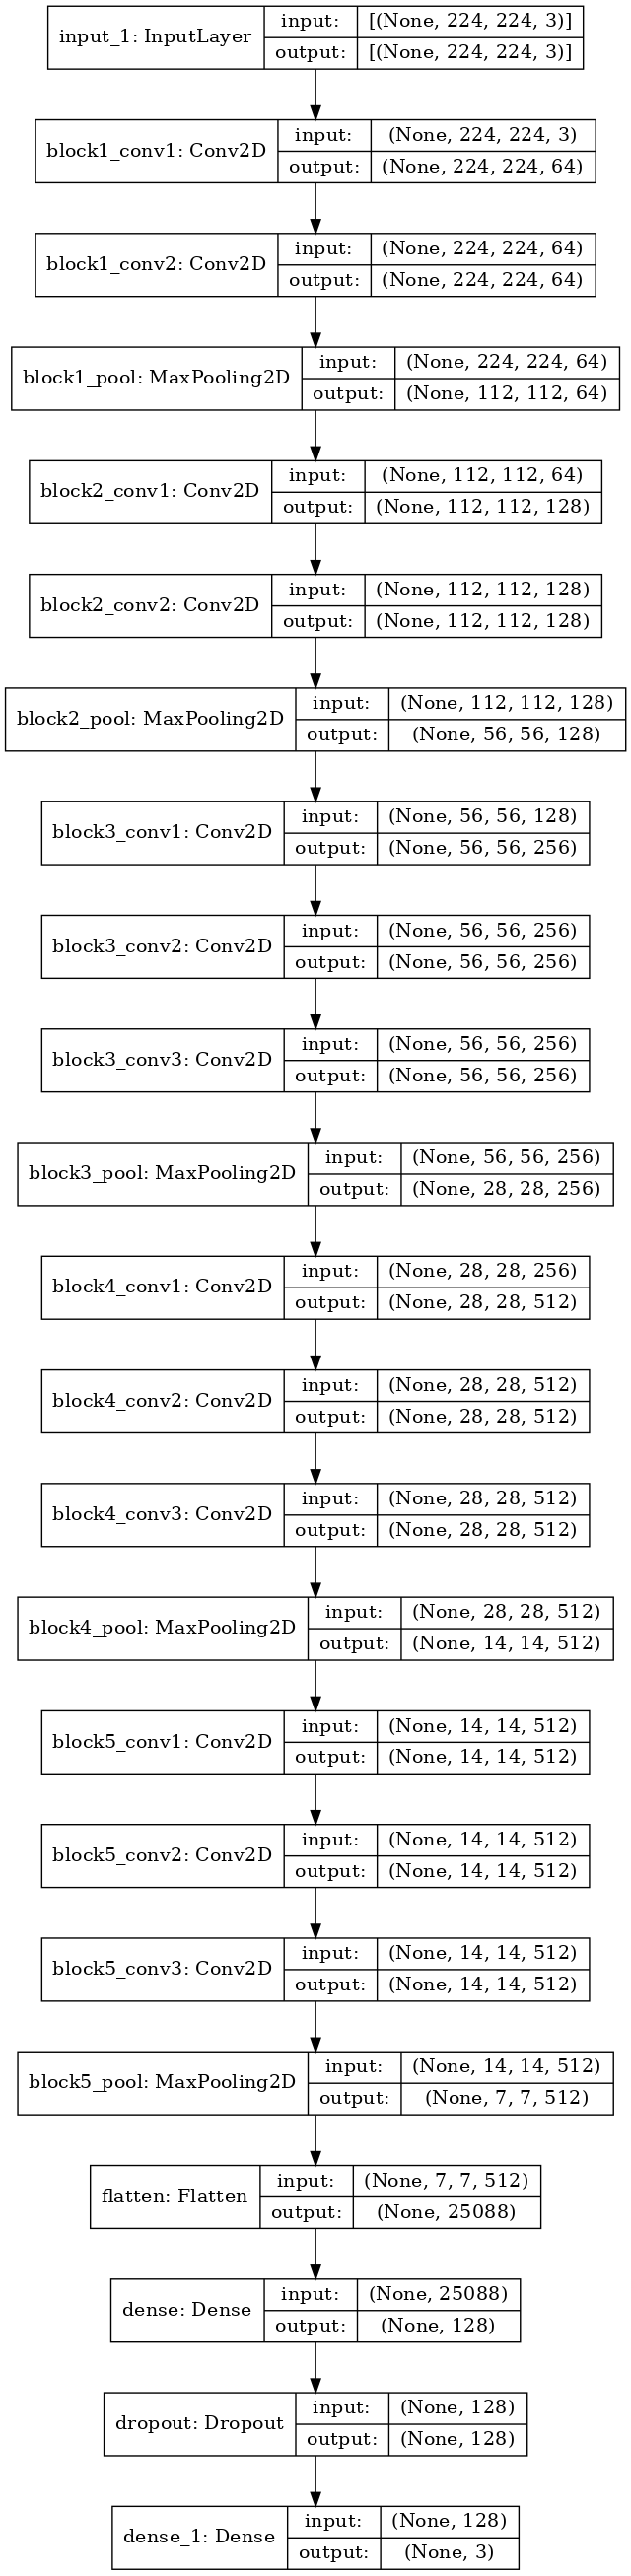

In [22]:
tf.keras.utils.plot_model(
    model,
    to_file="VGG16 model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=100,
)

In [23]:
METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc')
]

In [24]:
from keras.callbacks import EarlyStopping, TensorBoard
tensorboard = tf.keras.callbacks.TensorBoard(log_dir="./logs_VGG")
earlyStopping = EarlyStopping(monitor = 'val_loss', patience = 70, mode = 'min', restore_best_weights = True)

2022-10-16 11:43:57.350427: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-16 11:43:57.351151: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-10-16 11:43:57.353656: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2022-10-16 11:43:57.599004: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-10-16 11:43:57.599190: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


#### Optimizer - Adam

In [25]:
opt = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy']+ METRICS)

In [26]:
epochs = 30
history_VGG = model.fit_generator(train_generator,
                              validation_data=valid_generator, verbose=1, epochs=epochs,callbacks=[earlyStopping])

2022-10-16 11:43:58.187542: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-10-16 11:44:01.157008: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


250/250 [==============================] - 65s 221ms/step - loss: 0.6582 - accuracy: 0.7180 - tp: 2400.0000 - fp: 775.0000 - tn: 6707.0000 - fn: 1341.0000 - precision: 0.7559 - recall: 0.6415 - auc: 0.8833 - val_loss: 0.4648 - val_accuracy: 0.8017 - val_tp: 632.0000 - val_fp: 142.0000 - val_tn: 1462.0000 - val_fn: 170.0000 - val_precision: 0.8165 - val_recall: 0.7880 - val_auc: 0.9423
Epoch 2/30
250/250 [==============================] - 52s 209ms/step - loss: 0.4984 - accuracy: 0.8062 - tp: 2884.0000 - fp: 604.0000 - tn: 6878.0000 - fn: 857.0000 - precision: 0.8268 - recall: 0.7709 - auc: 0.9344 - val_loss: 0.4020 - val_accuracy: 0.8267 - val_tp: 658.0000 - val_fp: 127.0000 - val_tn: 1477.0000 - val_fn: 144.0000 - val_precision: 0.8382 - val_recall: 0.8204 - val_auc: 0.9586
Epoch 3/30
250/250 [==============================] - 54s 215ms/step - loss: 0.4561 - accuracy: 0.8284 - tp: 2986.0000 - fp: 543.0000 - tn: 6939.0000 - fn: 755.0000 - precision: 0.8461 - recall: 0.7982 - auc: 0.946

## Saving Model

In [27]:
model.save('VGG16_30epoc_0.5drop_7_3.h5')

In [28]:
vgg_model_acc_metrices = {
            'loss_vgg' : min(history_VGG.history['loss']),
            'val_loss_vgg' : min(history_VGG.history['val_loss']),
            'accuracy_vgg' : max(history_VGG.history['accuracy']),
            'val_accuracy_vgg' : max(history_VGG.history['val_accuracy']),
            'Precision_vgg' : max(history_VGG.history['precision']),
            'val_precision_vgg' : max(history_VGG.history['val_precision']),
            'Recall_vgg' : max(history_VGG.history['recall']),
            'val_recall_vgg' : max(history_VGG.history['val_recall']),
            'AUC_vgg' : max(history_VGG.history['auc']),
            'val_auc_vgg' : max(history_VGG.history['val_auc']),
            'TPR_vgg' : max(history_VGG.history['tp']),
            'TNR_vgg' : max(history_VGG.history['tn']),
            'FPR_vgg' : max(history_VGG.history['fp']),
            'FNR_vgg' : max(history_VGG.history['fn'])}

In [29]:
vgg_model_acc_metrices

{'loss_vgg': 0.32899054884910583,
 'val_loss_vgg': 0.29600828886032104,
 'accuracy_vgg': 0.8775728344917297,
 'val_accuracy_vgg': 0.895261824131012,
 'Precision_vgg': 0.8855735063552856,
 'val_precision_vgg': 0.8989899158477783,
 'Recall_vgg': 0.8647420406341553,
 'val_recall_vgg': 0.8915212154388428,
 'AUC_vgg': 0.9732709527015686,
 'val_auc_vgg': 0.9764556884765625,
 'TPR_vgg': 3235.0,
 'TNR_vgg': 7064.0,
 'FPR_vgg': 775.0,
 'FNR_vgg': 1341.0}

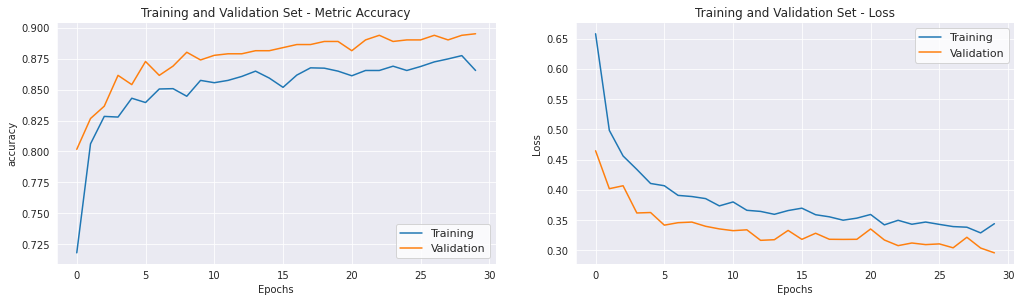

In [30]:
#Plot training, validation Loss and Accuracy
fig, axarr = plt.subplots(1,2, figsize=(15,5),sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)

history_VGG_df = pd.DataFrame.from_dict(history_VGG.history)
ax = sns.lineplot(x =history_VGG_df.index, y = history_VGG.history['accuracy'],ax=axarr[0],label="Training");
ax = sns.lineplot(x =history_VGG_df.index, y = history_VGG.history['val_accuracy'],ax=axarr[0],label="Validation");
ax.set_ylabel('accuracy')
ax = sns.lineplot(x =history_VGG_df.index, y = history_VGG.history['loss'],ax=axarr[1],label="Training");
ax = sns.lineplot(x =history_VGG_df.index, y = history_VGG.history['val_loss'],ax=axarr[1],label="Validation");
ax.set_ylabel('Loss')
# ax = sns.lineplot(x =historyVGG.index, y = history.history['lr'],ax=axarr[2]);
# ax.set_ylabel('Learning Rate')    
axarr[0].set_title("Training and Validation Set - Metric Accuracy")
axarr[1].set_title("Training and Validation Set - Loss")
# axarr[2].set_title("Learning Rate during Training")

for ax in axarr:
    ax.set_xlabel('Epochs')
    
fig.tight_layout(pad=3.0)      
plt.show()

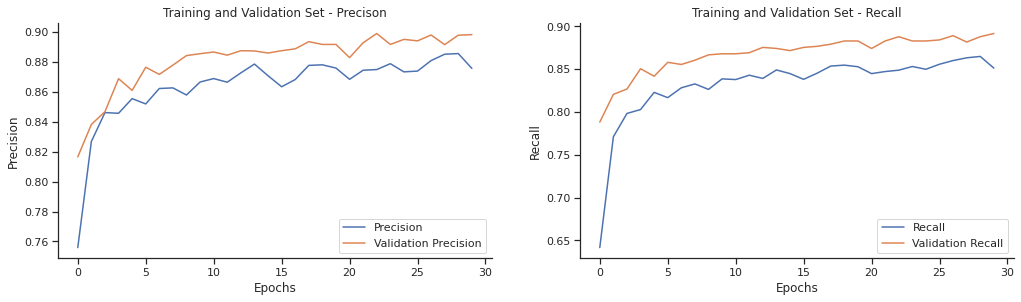

In [31]:
#Plot training, validation Precision and Recall
fig, axarr = plt.subplots(1,2, figsize=(15,5),sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)

history_VGG_df = pd.DataFrame.from_dict(history_VGG.history)
ax = sns.lineplot(x =history_VGG_df.index, y = history_VGG.history['precision'],ax=axarr[0],label="Precision");
ax = sns.lineplot(x =history_VGG_df.index, y = history_VGG.history['val_precision'],ax=axarr[0],label="Validation Precision");
ax.set_ylabel('Precision')
ax = sns.lineplot(x =history_VGG_df.index, y = history_VGG.history['recall'],ax=axarr[1],label="Recall");
ax = sns.lineplot(x =history_VGG_df.index, y = history_VGG.history['val_recall'],ax=axarr[1],label="Validation Recall");
ax.set_ylabel('Recall')
# ax = sns.lineplot(x =historyVGG.index, y = history.history['lr'],ax=axarr[2]);
# ax.set_ylabel('Learning Rate')    
axarr[0].set_title("Training and Validation Set - Precison")
axarr[1].set_title("Training and Validation Set - Recall")
# axarr[2].set_title("Learning Rate during Training")

for ax in axarr:
    ax.set_xlabel('Epochs')
    
fig.tight_layout(pad=3.0)      
plt.show()

<Figure size 432x288 with 0 Axes>

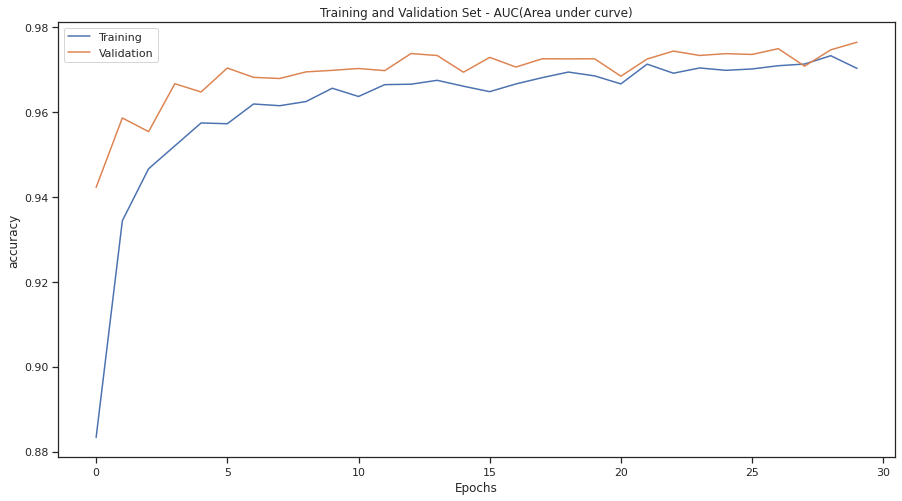

In [32]:
#Plot training and validation AUC

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.figure(figsize=(15,8))
history_VGG_df = pd.DataFrame.from_dict(history_VGG.history)
ax = sns.lineplot(x =history_VGG_df.index, y = history_VGG.history['auc'],label="Training");
ax = sns.lineplot(x =history_VGG_df.index, y = history_VGG.history['val_auc'],label="Validation");
ax.set_ylabel('accuracy')
ax.set_title("Training and Validation Set - AUC(Area under curve)")
ax.set_xlabel('Epochs')
fig.tight_layout(pad=3.0)      
plt.show()

In [33]:
y_pred = model.predict(valid_generator)

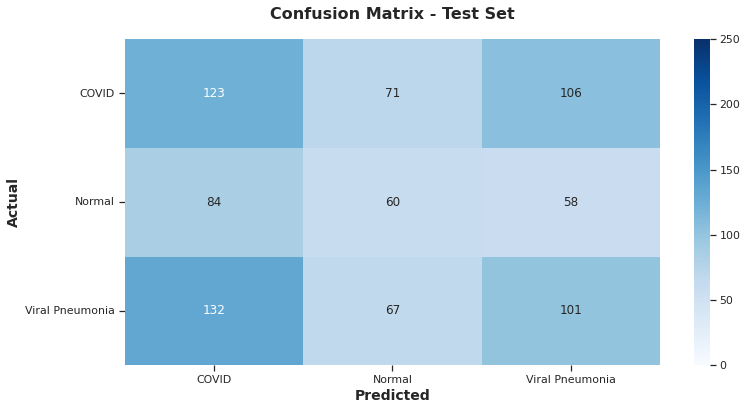

In [34]:
classes=["COVID", "Normal", "Viral Pneumonia"]
#transform the predictions into array such as [0,0,1,2...]
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))
#Retrieve the True classes of the test set
y_true=valid_generator.classes
#Build Confusion Matrix
CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

keras.backend.clear_session()

In [35]:
from sklearn.metrics import classification_report
print(classification_report(y_true, predictions))

              precision    recall  f1-score   support

           0       0.36      0.41      0.38       300
           1       0.30      0.30      0.30       202
           2       0.38      0.34      0.36       300

    accuracy                           0.35       802
   macro avg       0.35      0.35      0.35       802
weighted avg       0.35      0.35      0.35       802



## Plotting 
* Training & Validation Loss
* Training & Validation Loss

## Model Testing

True value is : Normal
Prediction is:
Viral Pneumonia


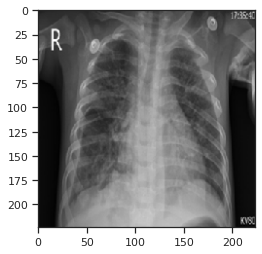

In [36]:
sample = random.choice(test_data['filename'])


category = sample.split('-')[0]
true = ''
if category == 'COVID':
    true = 'COVID'
elif category == 'Viral Pneumonia':
    true = 'Viral Pneumonia'
else:
    true = 'Normal'

print(f'True value is : {true}')
    
image = load_img(sample, target_size=(224, 224))
img = img_to_array(image)
img = img.reshape((1, 224, 224, 3))

result = model.predict(img)
result = np.argmax(result, axis=-1)
print('Prediction is:')
if result == 0:
    print("Normal")
elif result == 1:
    print("Viral Pneumonia")
else:
    print("COVID +")
    
plt.imshow(image)

# Model 2: ResNet50

In [37]:
import tensorflow as tf
import tensorflow
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Flatten, Dense, MaxPool2D, Dropout


In [38]:
CLASS_COUNT = 3

base_model_resnet = ResNet50(
    weights='imagenet',
    include_top=False, 
    input_shape=(224, 224, 3), 
    pooling='avg',
)
model_ResNet = Sequential([
  base_model_resnet,
   Dense(CLASS_COUNT, activation='softmax'),
])

94781440/94765736 [==============================] - 0s 0us/step


In [39]:
model_ResNet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 3)                 6147      
Total params: 23,593,859
Trainable params: 23,540,739
Non-trainable params: 53,120
_________________________________________________________________


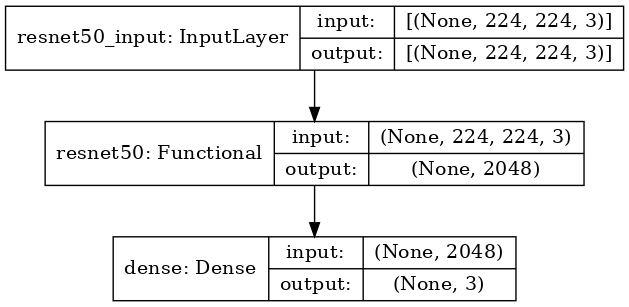

In [40]:
tf.keras.utils.plot_model(
    model_ResNet,
    to_file="ResNet model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=100,
)

In [41]:
tensorboard = tf.keras.callbacks.TensorBoard(log_dir="./logs_ResNet")
earlyStopping = EarlyStopping(monitor = 'val_loss', patience = 70, mode = 'min', restore_best_weights = True)

2022-10-16 12:12:33.728031: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-16 12:12:33.728091: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-10-16 12:12:34.024338: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-10-16 12:12:34.024551: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [42]:
opt = Adam(learning_rate=0.0001)
model_ResNet.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy']+METRICS)

In [43]:
epochs = 30
history_ResNet = model_ResNet.fit_generator(train_generator,
                              validation_data=valid_generator, verbose=1, epochs=epochs,callbacks=[earlyStopping])

Epoch 1/30
250/250 [==============================] - 69s 246ms/step - loss: 0.3176 - accuracy: 0.8776 - tp: 3968.0000 - fp: 509.0000 - tn: 8577.0000 - fn: 575.0000 - precision: 0.8863 - recall: 0.8734 - auc: 0.9722 - val_loss: 1.3528 - val_accuracy: 0.3741 - val_tp: 300.0000 - val_fp: 502.0000 - val_tn: 1102.0000 - val_fn: 502.0000 - val_precision: 0.3741 - val_recall: 0.3741 - val_auc: 0.5302
Epoch 2/30
250/250 [==============================] - 62s 248ms/step - loss: 0.1882 - accuracy: 0.9300 - tp: 3473.0000 - fp: 247.0000 - tn: 7235.0000 - fn: 268.0000 - precision: 0.9336 - recall: 0.9284 - auc: 0.9891 - val_loss: 1.6711 - val_accuracy: 0.3641 - val_tp: 253.0000 - val_fp: 484.0000 - val_tn: 1120.0000 - val_fn: 549.0000 - val_precision: 0.3433 - val_recall: 0.3155 - val_auc: 0.4947
Epoch 3/30
250/250 [==============================] - 60s 239ms/step - loss: 0.1477 - accuracy: 0.9457 - tp: 3529.0000 - fp: 195.0000 - tn: 7287.0000 - fn: 212.0000 - precision: 0.9476 - recall: 0.9433 - 

In [44]:
model_ResNet.save('ResNet_30epoc_0.5drop_7_3.h5')

In [45]:
resnet_model_acc_metrices = {
            'loss_resnet' : min(history_ResNet.history['loss']),
            'val_loss_resnet' : min(history_ResNet.history['val_loss']),
            'accuracy_resnet' : max(history_ResNet.history['accuracy']),
            'val_accuracy_resnet' : max(history_ResNet.history['val_accuracy']),
            'Precision_resnet' : max(history_ResNet.history['precision']),
            'val_precision_resnet' : max(history_ResNet.history['val_precision']),
            'Recall_resnet' : max(history_ResNet.history['recall']),
            'val_recall_resnet' : max(history_ResNet.history['val_recall']),
            'AUC_resnet' : max(history_ResNet.history['auc']),
            'val_auc_resnet' : max(history_ResNet.history['val_auc']),
            'TPR_resnet' : max(history_ResNet.history['tp']),
            'TNR_resnet' : max(history_ResNet.history['tn']),
            'FPR_resnet' : max(history_ResNet.history['fp']),
            'FNR_resnet' : max(history_ResNet.history['fn'])}

In [46]:
resnet_model_acc_metrices

{'loss_resnet': 0.01714644767343998,
 'val_loss_resnet': 0.08282425999641418,
 'accuracy_resnet': 0.9941192269325256,
 'val_accuracy_resnet': 0.975062370300293,
 'Precision_resnet': 0.9943835139274597,
 'val_precision_resnet': 0.975062370300293,
 'Recall_resnet': 0.993851900100708,
 'val_recall_resnet': 0.975062370300293,
 'AUC_resnet': 0.9999254941940308,
 'val_auc_resnet': 0.9971327185630798,
 'TPR_resnet': 3968.0,
 'TNR_resnet': 8577.0,
 'FPR_resnet': 509.0,
 'FNR_resnet': 575.0}

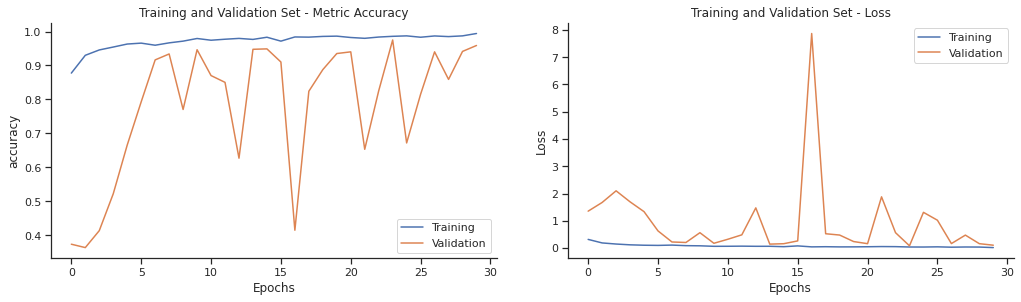

In [47]:
#Plot training, validation Loss and Accuracy
fig, axarr = plt.subplots(1,2, figsize=(15,5),sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)

history_ResNet_df = pd.DataFrame.from_dict(history_ResNet.history)
ax = sns.lineplot(x =history_ResNet_df.index, y = history_ResNet.history['accuracy'],ax=axarr[0],label="Training");
ax = sns.lineplot(x =history_ResNet_df.index, y = history_ResNet.history['val_accuracy'],ax=axarr[0],label="Validation");
ax.set_ylabel('accuracy')
ax = sns.lineplot(x =history_ResNet_df.index, y = history_ResNet.history['loss'],ax=axarr[1],label="Training");
ax = sns.lineplot(x =history_ResNet_df.index, y = history_ResNet.history['val_loss'],ax=axarr[1],label="Validation");
ax.set_ylabel('Loss')
# ax = sns.lineplot(x =historyVGG.index, y = history.history['lr'],ax=axarr[2]);
# ax.set_ylabel('Learning Rate')    
axarr[0].set_title("Training and Validation Set - Metric Accuracy")
axarr[1].set_title("Training and Validation Set - Loss")
# axarr[2].set_title("Learning Rate during Training")

for ax in axarr:
    ax.set_xlabel('Epochs')
    
fig.tight_layout(pad=3.0)      
plt.show()

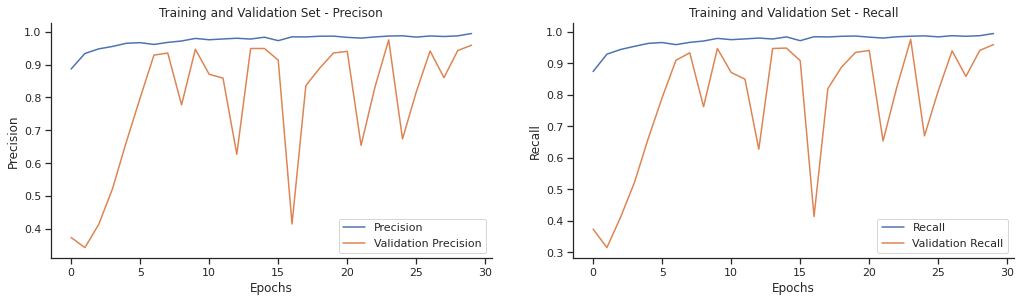

In [48]:
#Plot training, validation Precision and Recall
fig, axarr = plt.subplots(1,2, figsize=(15,5),sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)

history_ResNet_df = pd.DataFrame.from_dict(history_ResNet.history)
ax = sns.lineplot(x =history_ResNet_df.index, y = history_ResNet.history['precision'],ax=axarr[0],label="Precision");
ax = sns.lineplot(x =history_ResNet_df.index, y = history_ResNet.history['val_precision'],ax=axarr[0],label="Validation Precision");
ax.set_ylabel('Precision')
ax = sns.lineplot(x =history_ResNet_df.index, y = history_ResNet.history['recall'],ax=axarr[1],label="Recall");
ax = sns.lineplot(x =history_ResNet_df.index, y = history_ResNet.history['val_recall'],ax=axarr[1],label="Validation Recall");
ax.set_ylabel('Recall') 
axarr[0].set_title("Training and Validation Set - Precison")
axarr[1].set_title("Training and Validation Set - Recall")
# axarr[2].set_title("Learning Rate during Training")

for ax in axarr:
    ax.set_xlabel('Epochs')
    
fig.tight_layout(pad=3.0)      
plt.show()

<Figure size 432x288 with 0 Axes>

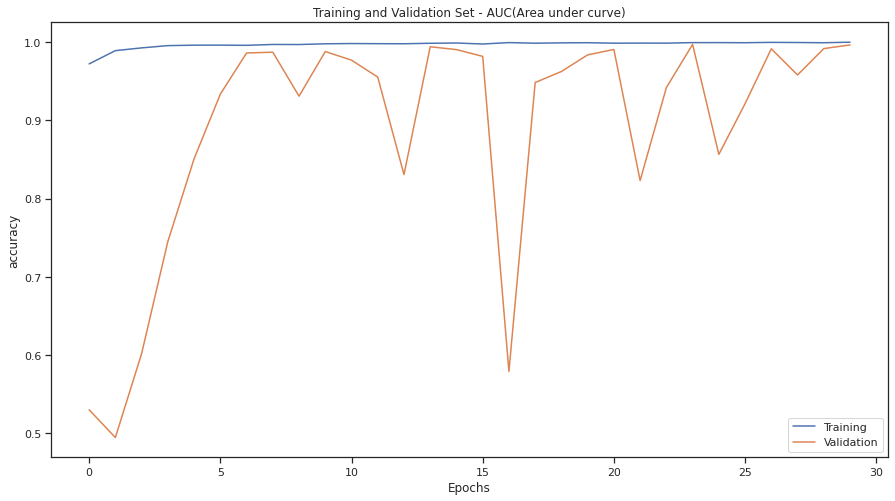

In [49]:
#Plot training and validation AUC

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.figure(figsize=(15,8))
history_ResNet_df = pd.DataFrame.from_dict(history_ResNet.history)
ax = sns.lineplot(x =history_ResNet_df.index, y = history_ResNet.history['auc'],label="Training");
ax = sns.lineplot(x =history_ResNet_df.index, y = history_ResNet.history['val_auc'],label="Validation");
ax.set_ylabel('accuracy')
ax.set_title("Training and Validation Set - AUC(Area under curve)")
ax.set_xlabel('Epochs')
fig.tight_layout(pad=3.0)      
plt.show()

In [50]:
y_pred = model_ResNet.predict(valid_generator)

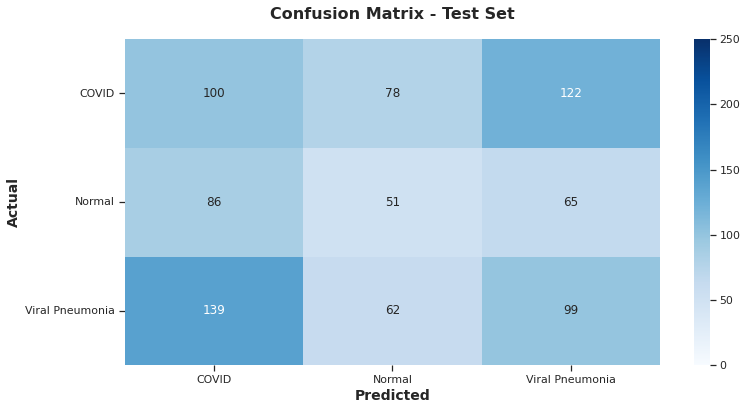

In [51]:
classes=["COVID", "Normal", "Viral Pneumonia"]
#transform the predictions into array such as [0,0,1,2...]
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))
#Retrieve the True classes of the test set
y_true=valid_generator.classes
#Build Confusion Matrix
CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

keras.backend.clear_session()

In [52]:
from sklearn.metrics import classification_report
print(classification_report(y_true, predictions))

              precision    recall  f1-score   support

           0       0.31      0.33      0.32       300
           1       0.27      0.25      0.26       202
           2       0.35      0.33      0.34       300

    accuracy                           0.31       802
   macro avg       0.31      0.31      0.31       802
weighted avg       0.31      0.31      0.31       802



True value is : Normal
Prediction is:
COVID +


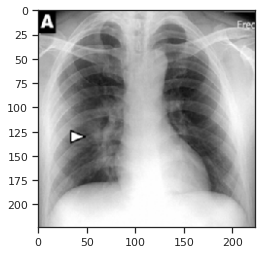

In [53]:
sample = random.choice(test_data['filename'])


category = sample.split('-')[0]
true = ''
if category == 'COVID':
    true = 'COVID'
elif category == 'Viral Pneumonia':
    true = 'Viral Pneumonia'
else:
    true = 'Normal'

print(f'True value is : {true}')
    
image = load_img(sample, target_size=(224, 224))
img = img_to_array(image)
img = img.reshape((1, 224, 224, 3))

result = model_ResNet.predict(img)
result = np.argmax(result, axis=-1)
print('Prediction is:')
if result == 0:
    print("Normal")
elif result == 1:
    print("Viral Pneumonia")
else:
    print("COVID +")
    
plt.imshow(image)

# Model 3:DenseNet model

In [54]:
from tensorflow.keras.applications import DenseNet121

In [55]:
# baseModel_DenseNet = DenseNet121(
#     weights='imagenet',
#     include_top=False,
#     input_shape=(224,224,3)
# )
CLASS_COUNT = 3

base_model_densenet = DenseNet121(
    weights='imagenet',
    include_top=False, 
    input_shape=(224, 224, 3), 
    pooling='avg',
)
model_DenseNet = Sequential([
  base_model_densenet,
   Dense(CLASS_COUNT, activation='softmax'),
])

29097984/29084464 [==============================] - 0s 0us/step


In [56]:
# for layer in baseModel_DenseNet.layers:
#     layer.trainable = False

# # headModel_DenseNet = baseModel_DenseNet.output
# # headModel_DenseNet = AveragePooling2D()(headModel_DenseNet)
# # headModel_DenseNet = Flatten()(headModel_DenseNet)
# # headModel_DenseNet = Dense(512, activation="relu")(headModel_DenseNet)
# # headModel_DenseNet = Dropout(0.4)(headModel_DenseNet)
# # headModel_DenseNet = Dense(3, activation='softmax')(headModel_DenseNet)

# # model_DenseNet = Model(inputs=baseModel_DenseNet.input, outputs=headModel_DenseNet)
# headModel = baseModel.output
# headModel = Flatten(name="flatten")(headModel)
# headModel = Dense(64, activation="relu")(headModel)
# headModel = Dropout(0.5)(headModel)
# headModel = Dense(3, activation="softmax")(headModel)
# model = Model(inputs=baseModel.input, outputs=headModel)
# for layer in baseModel.layers:
#     layer.trainable = False


In [57]:
model_DenseNet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 1024)              7037504   
_________________________________________________________________
dense (Dense)                (None, 3)                 3075      
Total params: 7,040,579
Trainable params: 6,956,931
Non-trainable params: 83,648
_________________________________________________________________


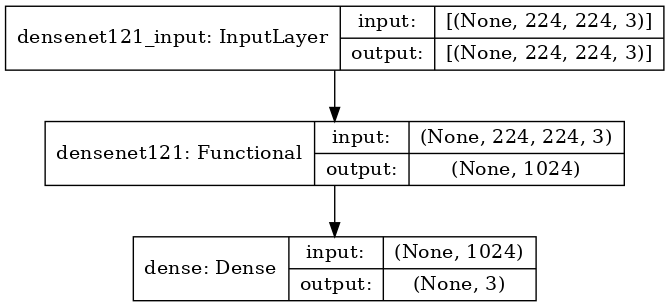

In [58]:
tf.keras.utils.plot_model(
    model_DenseNet,
    to_file="DenseNet model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=100,
)

In [59]:
tensorboard = tf.keras.callbacks.TensorBoard(log_dir="./logs_DenseNet")
earlyStopping = EarlyStopping(monitor = 'val_loss', patience = 70, mode = 'min', restore_best_weights = True)

2022-10-16 12:45:29.966270: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-10-16 12:45:29.966327: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-10-16 12:45:30.247131: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-10-16 12:45:30.247329: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [60]:
opt = Adam(learning_rate=0.0001)
model_DenseNet.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy']+METRICS)

In [61]:
epochs = 30
history_DenseNet = model_DenseNet.fit_generator(train_generator,
                              validation_data=valid_generator, verbose=1, epochs=epochs,callbacks=[earlyStopping])

Epoch 1/30
250/250 [==============================] - 76s 258ms/step - loss: 0.3492 - accuracy: 0.8634 - tp: 3949.0000 - fp: 498.0000 - tn: 8588.0000 - fn: 594.0000 - precision: 0.8880 - recall: 0.8692 - auc: 0.9741 - val_loss: 0.3571 - val_accuracy: 0.8753 - val_tp: 686.0000 - val_fp: 89.0000 - val_tn: 1515.0000 - val_fn: 116.0000 - val_precision: 0.8852 - val_recall: 0.8554 - val_auc: 0.9651
Epoch 2/30
250/250 [==============================] - 62s 247ms/step - loss: 0.1982 - accuracy: 0.9260 - tp: 3455.0000 - fp: 262.0000 - tn: 7220.0000 - fn: 286.0000 - precision: 0.9295 - recall: 0.9235 - auc: 0.9878 - val_loss: 0.7637 - val_accuracy: 0.6621 - val_tp: 525.0000 - val_fp: 262.0000 - val_tn: 1342.0000 - val_fn: 277.0000 - val_precision: 0.6671 - val_recall: 0.6546 - val_auc: 0.8806
Epoch 3/30
250/250 [==============================] - 61s 246ms/step - loss: 0.1623 - accuracy: 0.9407 - tp: 3512.0000 - fp: 217.0000 - tn: 7265.0000 - fn: 229.0000 - precision: 0.9418 - recall: 0.9388 - a

In [62]:
model_DenseNet.save('DenseNet_30_epoc_0.5drop_7_3.h5')

In [63]:
densenet_model_acc_metrices = {
            'loss_densenet' : min(history_DenseNet.history['loss']),
            'val_loss_densenet' : min(history_DenseNet.history['val_loss']),
            'accuracy_densenet' : max(history_DenseNet.history['accuracy']),
            'val_accuracy_densenet' : max(history_DenseNet.history['val_accuracy']),
            'Precision_resnet' : max(history_DenseNet.history['precision']),
            'val_precision_densenet' : max(history_DenseNet.history['val_precision']),
            'Recall_densenet' : max(history_DenseNet.history['recall']),
            'val_recall_densenet' : max(history_DenseNet.history['val_recall']),
            'AUC_densenet' : max(history_DenseNet.history['auc']),
            'val_auc_densenet' : max(history_DenseNet.history['val_auc']),
            'TPR_densenet' : max(history_DenseNet.history['tp']),
            'TNR_densenet' : max(history_DenseNet.history['tn']),
            'FPR_densenet' : max(history_DenseNet.history['fp']),
            'FNR_densenet' : max(history_DenseNet.history['fn'])}

In [64]:
densenet_model_acc_metrices

{'loss_densenet': 0.024875115603208542,
 'val_loss_densenet': 0.0658724308013916,
 'accuracy_densenet': 0.9919807314872742,
 'val_accuracy_densenet': 0.9763092398643494,
 'Precision_resnet': 0.9922459721565247,
 'val_precision_densenet': 0.9763092398643494,
 'Recall_densenet': 0.9919807314872742,
 'val_recall_densenet': 0.9763092398643494,
 'AUC_densenet': 0.9998170733451843,
 'val_auc_densenet': 0.9979512095451355,
 'TPR_densenet': 3949.0,
 'TNR_densenet': 8588.0,
 'FPR_densenet': 498.0,
 'FNR_densenet': 594.0}

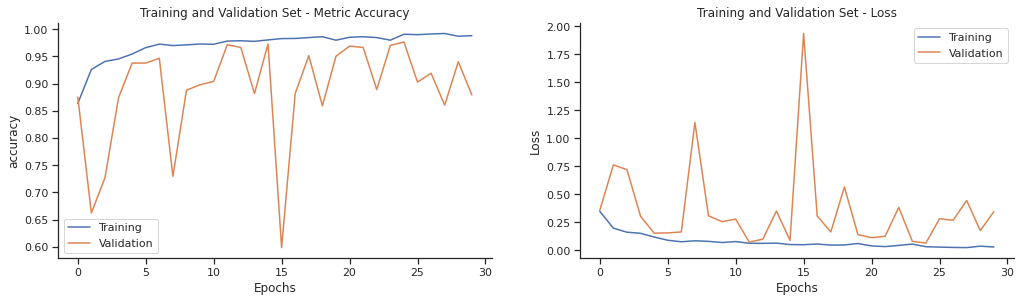

In [65]:
#Plot training, validation Loss and Accuracy
fig, axarr = plt.subplots(1,2, figsize=(15,5),sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)

history_DenseNet_df = pd.DataFrame.from_dict(history_DenseNet.history)
ax = sns.lineplot(x =history_DenseNet_df.index, y = history_DenseNet.history['accuracy'],ax=axarr[0],label="Training");
ax = sns.lineplot(x =history_DenseNet_df.index, y = history_DenseNet.history['val_accuracy'],ax=axarr[0],label="Validation");
ax.set_ylabel('accuracy')
ax = sns.lineplot(x =history_DenseNet_df.index, y = history_DenseNet.history['loss'],ax=axarr[1],label="Training");
ax = sns.lineplot(x =history_DenseNet_df.index, y = history_DenseNet.history['val_loss'],ax=axarr[1],label="Validation");
ax.set_ylabel('Loss')
# ax = sns.lineplot(x =historyVGG.index, y = history.history['lr'],ax=axarr[2]);
# ax.set_ylabel('Learning Rate')    
axarr[0].set_title("Training and Validation Set - Metric Accuracy")
axarr[1].set_title("Training and Validation Set - Loss")
# axarr[2].set_title("Learning Rate during Training")

for ax in axarr:
    ax.set_xlabel('Epochs')
    
fig.tight_layout(pad=3.0)      
plt.show()

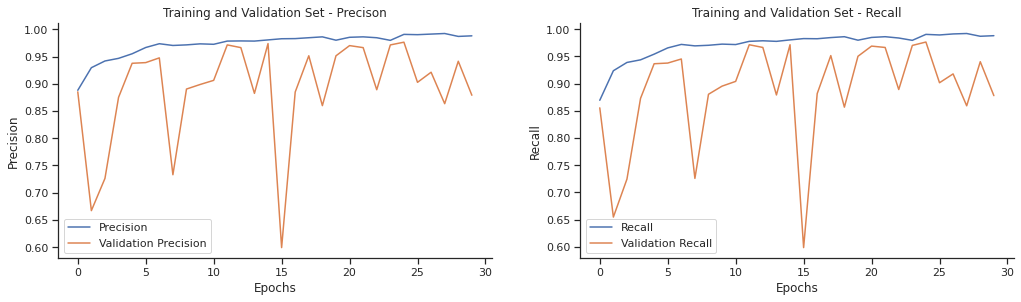

In [66]:
#Plot training, validation Precision and Recall
fig, axarr = plt.subplots(1,2, figsize=(15,5),sharex=True)

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)

history_DenseNet_df = pd.DataFrame.from_dict(history_DenseNet.history)
ax = sns.lineplot(x =history_DenseNet_df.index, y = history_DenseNet.history['precision'],ax=axarr[0],label="Precision");
ax = sns.lineplot(x =history_DenseNet_df.index, y = history_DenseNet.history['val_precision'],ax=axarr[0],label="Validation Precision");
ax.set_ylabel('Precision')
ax = sns.lineplot(x =history_DenseNet_df.index, y = history_DenseNet.history['recall'],ax=axarr[1],label="Recall");
ax = sns.lineplot(x =history_DenseNet_df.index, y = history_DenseNet.history['val_recall'],ax=axarr[1],label="Validation Recall");
ax.set_ylabel('Recall')   
axarr[0].set_title("Training and Validation Set - Precison")
axarr[1].set_title("Training and Validation Set - Recall")
# axarr[2].set_title("Learning Rate during Training")

for ax in axarr:
    ax.set_xlabel('Epochs')
    
fig.tight_layout(pad=3.0)      
plt.show()

<Figure size 432x288 with 0 Axes>

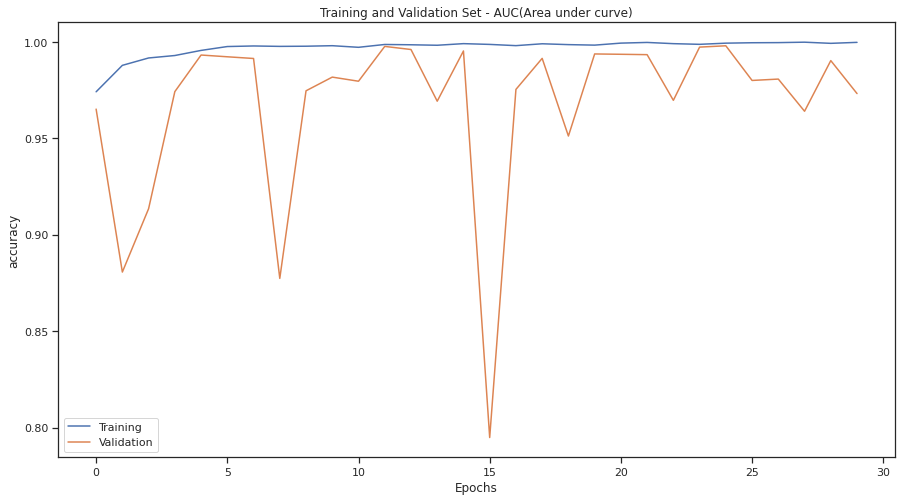

In [67]:
#Plot training and validation AUC

sns.set(style="ticks", font_scale = 1)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.figure(figsize=(15,8))
history_DenseNet_df = pd.DataFrame.from_dict(history_DenseNet.history)
ax = sns.lineplot(x =history_DenseNet_df.index, y = history_DenseNet.history['auc'],label="Training");
ax = sns.lineplot(x =history_DenseNet_df.index, y = history_DenseNet.history['val_auc'],label="Validation");
ax.set_ylabel('accuracy')
ax.set_title("Training and Validation Set - AUC(Area under curve)")
ax.set_xlabel('Epochs')
fig.tight_layout(pad=3.0)      
plt.show()

In [68]:
y_pred = model_DenseNet.predict(valid_generator)

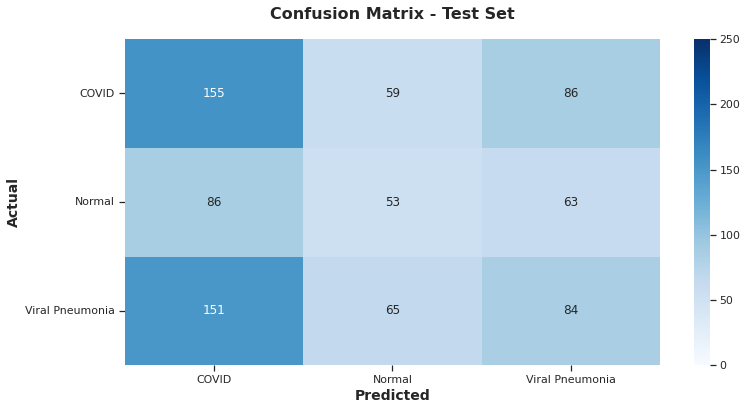

In [69]:
classes=["COVID", "Normal", "Viral Pneumonia"]
#transform the predictions into array such as [0,0,1,2...]
predictions = np.array(list(map(lambda x: np.argmax(x), y_pred)))
#Retrieve the True classes of the test set
y_true=valid_generator.classes
#Build Confusion Matrix
CMatrix = pd.DataFrame(confusion_matrix(y_true, predictions), columns=classes, index =classes)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 250,cmap = 'Blues')
ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold')
ax.set_xticklabels(ax.get_xticklabels(),rotation =0);

ax.set_ylabel('Actual',fontsize = 14,weight = 'bold') 
ax.set_yticklabels(ax.get_yticklabels(),rotation =0);
ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);

keras.backend.clear_session()

True value is : Normal
Prediction is:
Normal


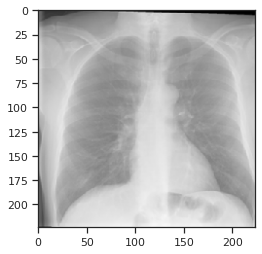

In [70]:
sample = random.choice(test_data['filename'])


category = sample.split('-')[0]
true = ''
if category == 'COVID':
    true = 'COVID'
elif category == 'Viral Pneumonia':
    true = 'Viral Pneumonia'
else:
    true = 'Normal'

print(f'True value is : {true}')
    
image = load_img(sample, target_size=(224, 224))
img = img_to_array(image)
img = img.reshape((1, 224, 224, 3))

result = model_DenseNet.predict(img)
result = np.argmax(result, axis=-1)
print('Prediction is:')
if result == 0:
    print("Normal")
elif result == 1:
    print("Viral Pneumonia")
else:
    print("COVID +")
    
plt.imshow(image)

In [71]:
# model1 = tf.keras.models.load_model('./VGG16_30epoc_0.5drop.h5')

# model2 = tf.keras.models.load_model('./ResNet_30epoc_0.5drop.h5')

# model3 = tf.keras.models.load_model('./DenseNet_30_epoc_0.5drop.h5')

In [72]:
# ! pip install deepstack

In [73]:
# from deepstack.base import KerasMember

# member1 = KerasMember(name="model1", keras_model=model1, train_batches=train_generator, val_batches=valid_generator)
# member2 = KerasMember(name="model2", keras_model=model2, train_batches=train_generator, val_batches=valid_generator)
# member3 = KerasMember(name="model3", keras_model=model3, train_batches=train_generator, val_batches=valid_generator)

In [74]:
# from tensorflow.keras.utils import to_categorical
# from deepstack.ensemble import StackEnsemble
# import sklearn
# from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import StackingClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import ExtraTreesClassifier

# #Ensure you have the scikit-learn version >= 0.22 installed
# print("sklearn version must be >= 0.22. You have:", sklearn.__version__)

# stack = StackEnsemble()

# # 2nd Level Meta-Learner
# estimators = [
#     ('rf', RandomForestClassifier(verbose=0, n_estimators=200, max_depth=15, n_jobs=20, min_samples_split=30)),
#     ('etr', ExtraTreesClassifier(verbose=0, n_estimators=200, max_depth=10, n_jobs=20, min_samples_split=20))
# ]
# # 3rd Level Meta-Learner
# clf = StackingClassifier(
#     estimators=estimators, final_estimator=LogisticRegression()
# )

# stack.model = clf
# stack.add_members([member1, member2, member3])
# stack.fit()
# stack.describe(metric=sklearn.metrics.accuracy_score)